In [ ]:
# !pip3 install dblur --break-system-packages
# !pip3 install --upgrade dblur --break-system-packages

# Libraries

In [ ]:
import os
import piexif
import cv2
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm
from pprint import pprint
from pathlib import Path

from rembg import remove 
from PIL import Image 

from dblur.testers.mscnn import MSCNNTester
from dblur.testers.stack_dmphn import StackDMPHNTester
from dblur.multi_modal_deblur import multi_modal_deblur

# Main

In [ ]:
mscnn_tester = MSCNNTester()
model1 = mscnn_tester.get_model()

dmphn_tester = StackDMPHNTester()
model2 = dmphn_tester.get_model(num_of_stacks=1)

blur_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_50_3/1/1D0L/frame_0000.jpeg'
sharp_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/frame_0000.jpeg'

multi_modal_deblur(models=[model1, model2], 
                   model_names=["MSCNN", "StackDMPHN"],
                #    model_paths=[model_path1, model_path2],
                   blur_img_path=blur_img_path,
                   sharp_img_path=sharp_img_path,
                   is_checkpoint=[True, True], 
                   window_slicing=True, 
                   window_size=256, 
                   overlap_size=0)

(-0.5, 539.5, 959.5, -0.5)

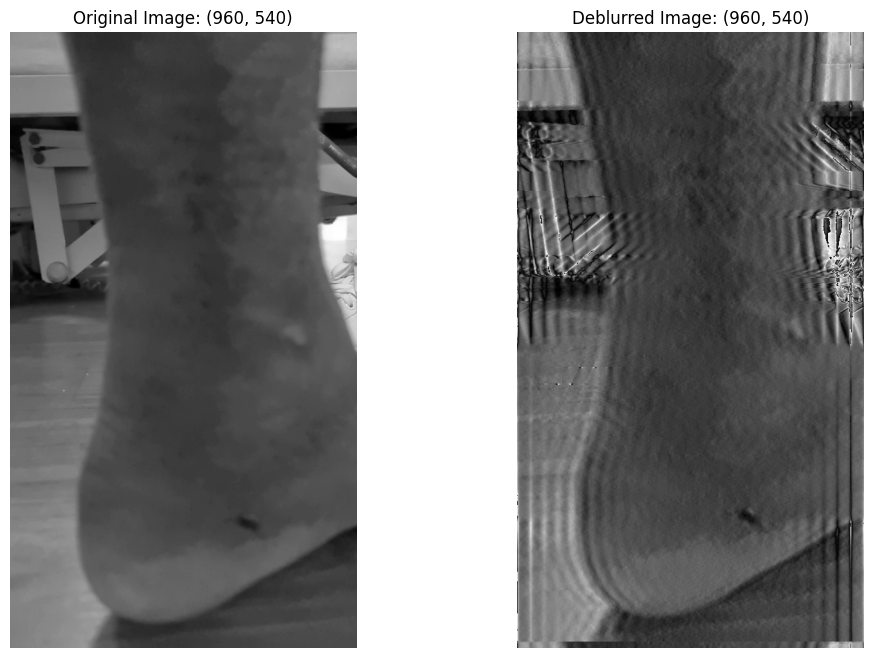

In [ ]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s=img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return np.uint8(dummy)

blur_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_50_3/13/13D0L/frame_0000.jpeg'
sharp_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/frame_0004.jpeg'

# Load your image
img = cv2.imread(blur_img_path, 0)

# Define the kernel (e.g., motion blur kernel)
value = 21
# value = 5
kernel = np.zeros((value, value))
kernel[10, :] = np.ones(value)
# kernel[5, :] = np.ones(value)
# kernel[3, :] = np.ones(value)
kernel = kernel / value

# Apply Wiener filter
# deblurred_img = wiener_filter(img, kernel, 0.01)
deblurred_img = wiener_filter(img, kernel, 0.01)

# Save or display the deblurred image
# cv2.imwrite('deblurred_image.jpg', deblurred_img)

# Display both images side by side
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(1, 2, 1)
plt.title(f'Original Image: {img.shape}')
plt.imshow(img, cmap='gray')
plt.axis('off')

# Deblurred image
plt.subplot(1, 2, 2)
plt.title(f'Deblurred Image: {deblurred_img.shape}')
plt.imshow(deblurred_img, cmap='gray')
plt.axis('off')

Predicted label: blur


TypeError: Invalid shape (3, 224, 224) for image data

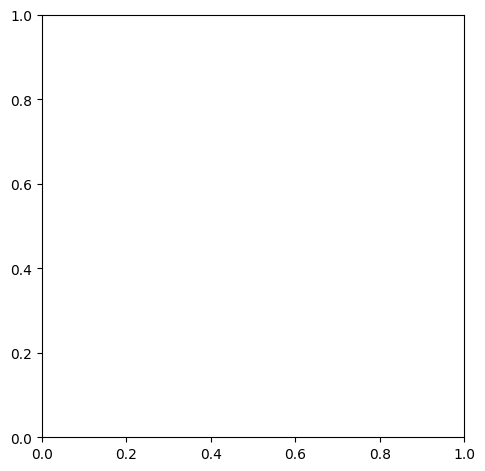

In [49]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch

# Load model and processor
model = ViTForImageClassification.from_pretrained("harrytechiz/vit-base-patch16-224-blur_vs_clean")
processor = ViTImageProcessor.from_pretrained("harrytechiz/vit-base-patch16-224-blur_vs_clean")

blur_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_50_3/13/13D0L/frame_0000.jpeg'
sharp_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/frame_0004.jpeg'


# Load and preprocess image
image = Image.open(blur_img_path)
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    attentions = outputs.attentions[-1] # Last layer attention

# Average attention across all heads
attention_map = attentions.mean(dim=1).squeeze().numpy()


# Get label
label = model.config.id2label[predicted_class]
print(f"Predicted label: {label}")

# Plot input image and attention map
plt.figure(figsize=(12, 6))

# Input image
plt.subplot(1, 2, 1)
plt.imshow(np.array(tf.squeeze(inputs['pixel_values'])))
plt.title("Input Image")
plt.axis('off')

# Attention map
plt.subplot(1, 2, 2)
plt.imshow(attention_map, cmap='viridis', interpolation='nearest')
plt.title(f"Predicted label: {model.config.id2label[predicted_class]}")
plt.axis('off')

plt.tight_layout()
plt.show()



In [48]:
np.array(tf.squeeze(inputs['pixel_values'])).shape

(3, 224, 224)

In [52]:

from huggingface_hub import from_pretrained_keras
from PIL import Image

import tensorflow as tf
from keras.layers import TFSMLayer

import numpy as np
import requests

blur_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_50_3/13/13D0L/frame_0000.jpeg'
sharp_img_path = '/home/weiyanpeh/Git/SFM_Related/CADENCE/frame_0004.jpeg'

# Load and preprocess image
image = Image.open(blur_img_path)

image = image.resize((256, 256))
image = np.array(image) / 255.0
image = tf.convert_to_tensor(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)


# Load the model using TFSMLayer
model_path = "model/google/maxim-s3-deblurring-realblur-r"
layer = TFSMLayer(model_path, call_endpoint="serving_default")

# Run inference
output = layer(image)



E0000 00:00:1748927111.985150    9960 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-06-03 13:05:11.987438: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at conv_ops_impl.h:1204 : INVALID_ARGUMENT: No DNN in stream executor.
2025-06-03 13:05:11.987498: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: No DNN in stream executor.
	 [[{{function_node __inference__wrapped_model_163842}}{{node s3_model/stage_0_input_conv_0/Conv2D}}]]
2025-06-03 13:05:11.987512: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: No DNN in strea

InvalidArgumentError: Exception encountered when calling TFSMLayer.call().

[1mGraph execution error:

Detected at node s3_model/stage_0_input_conv_0/Conv2D defined at (most recent call last):
<stack traces unavailable>
Detected at node s3_model/stage_0_input_conv_0/Conv2D defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  No DNN in stream executor.
	 [[{{node s3_model/stage_0_input_conv_0/Conv2D}}]]
	 [[StatefulPartitionedCall/s3_model/UpSampleRatio_26_resizing_28/resize/truediv/_2400]]
  (1) INVALID_ARGUMENT:  No DNN in stream executor.
	 [[{{node s3_model/stage_0_input_conv_0/Conv2D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_signature_wrapper_166617][0m

Arguments received by TFSMLayer.call():
  • inputs=tf.Tensor(shape=(1, 256, 256, 3), dtype=float32)
  • training=False
  • kwargs=<class 'inspect._empty'>

In [36]:
predicted_class

0

In [30]:
inputs

{'pixel_values': tensor([[[[ 0.0431,  0.0510,  0.0588,  ...,  0.1686,  0.1686,  0.1529],
          [ 0.0431,  0.0431,  0.0588,  ...,  0.2784,  0.2706,  0.2627],
          [ 0.0510,  0.0510,  0.0667,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [ 0.0196,  0.0275,  0.0353,  ..., -0.1686, -0.1686, -0.1608],
          [ 0.0118,  0.0275,  0.0353,  ..., -0.1686, -0.1686, -0.1686],
          [ 0.0118,  0.0275,  0.0431,  ..., -0.1686, -0.1686, -0.1686]],

         [[ 0.1137,  0.1216,  0.1294,  ...,  0.3333,  0.3333,  0.3176],
          [ 0.1137,  0.1137,  0.1294,  ...,  0.4510,  0.4431,  0.4353],
          [ 0.1216,  0.1216,  0.1373,  ...,  0.4588,  0.4588,  0.4588],
          ...,
          [-0.0275, -0.0196, -0.0118,  ..., -0.4824, -0.4824, -0.4745],
          [-0.0353, -0.0196, -0.0118,  ..., -0.4824, -0.4824, -0.4824],
          [-0.0353, -0.0196, -0.0039,  ..., -0.4824, -0.4824, -0.4824]],

         [[ 0.1686,  0.1765,  0.1843,  ...,  0.6863,  0.6863,  0.6784],
          [ 0

TypeError: Image data of dtype <U12 cannot be converted to float

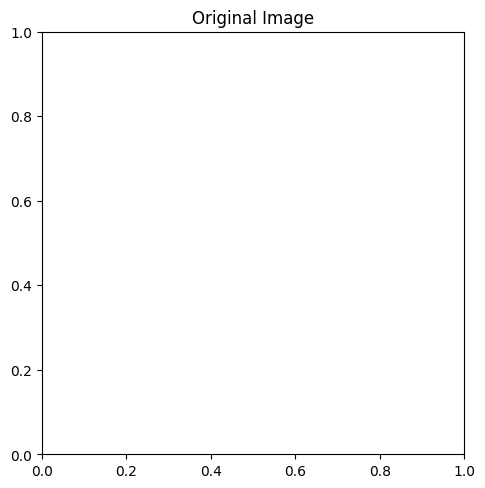

In [32]:
# Display both images side by side
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(1, 2, 1)
plt.title(f'Original Image')
plt.imshow(inputs, cmap='gray')
plt.axis('off')

# Deblurred image
plt.subplot(1, 2, 2)
plt.title(f'Deblurred Image')
plt.imshow(outputs, cmap='gray')
plt.axis('off')

# Functions

In [ ]:
# Get a list of all files and folders in the specified directory
def get_folders_in_directory(directory):
    items = os.listdir(directory)
    
    # Filter out the items that are folders
    folders = [item for item in items if os.path.isdir(os.path.join(directory, item))]
    
    return folders

def list_directory_contents(directory):
    # Get a list of all files and folders in the specified directory
    items = os.listdir(directory)
    
    return items


In [ ]:
# Specify the directory path
directory_path = f'/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_100_30'

# Get the list of folders in the directory
folders = get_folders_in_directory(directory_path)
# folders = [x for x in folders if 'Subject' in x]
folders.sort()

# Print the list of folders
pprint(folders)

In [ ]:
subject_dic = {}

for folder in folders:
    folder_path = os.path.join(directory_path, folder)
    
    # Get the list of files and folders in the directory
    contents = list_directory_contents(folder_path)
    contents = [x for x in contents if ':Zone.Identifier' not in x]
    
    subject_dic[folder] = contents
    
    for content in contents:
        folder_path_content = os.path.join(directory_path, folder, content)
        
        images = list_directory_contents(folder_path_content)
        images = [x for x in images if ':Zone.Identifier' not in x]
        
        print()
        print('#'*60)
        print(folder_path_content)
        print(images)
    

In [ ]:
subject_dic

# Using traditional models

In [ ]:
list_algorithm = [
    '',
    # '_colmap',
    # 'mve',
    # 'vggsfm'
    ]

list_scale_percent = [100, 50]
list_max_frames = [30, 45]

for scale_percent, max_frames in itertools.product(list_scale_percent, list_max_frames):
    print(f'Scale: {scale_percent}, Max Frames: {max_frames}')
    
    for subject in subject_dic.keys():    
        print('Subject', subject)
        folders = subject_dic[subject]
        
        for folder in folders:
            # When the input is raw
            # Convert to no bg (with/without resize)        
            path_input = f'/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input'
            path_output = f'/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input'

            path_input = os.path.join(f'{path_input}_{scale_percent}_{max_frames}', subject, folder)
            folder_path = Path(path_input)
                            
            ##################################################################
            # Loop through all files in the folder
            ##################################################################
            for file_path in tqdm(list(folder_path.iterdir()), total=len(list(folder_path.iterdir()))):
                if (
                    file_path.is_file() and 
                    ('.jpeg' in file_path.name) and 
                    (':Zone.Identifier' not in file_path.name)
                    ):

                    input_image_name = file_path.name
                    
                    file_path_input = os.path.join(path_input, input_image_name)
                    
                    # Processing the image 
                    # Removing the background from the given Image
                    input_img = Image.open(file_path_input)
                    input_img = remove(input_img) 
                    input_img = input_img.convert("RGB")

                    for algorithm in list_algorithm:
                        if algorithm == '':
                            file_path_output = os.path.join(f'{path_output}{algorithm}_{scale_percent}_{max_frames}_no_bg', subject, folder)  
                        else:
                            file_path_output = os.path.join(f'{path_output}{algorithm}_{scale_percent}_{max_frames}_no_bg', subject, folder, 'images')  
                    
                        if not os.path.exists(file_path_output):
                            os.makedirs(file_path_output)
                    
                        # print('')
                        # print(file_path_input)
                        # print(file_path_output)
                    
                        # Saving data
                        input_img.save(os.path.join(file_path_output, input_image_name))
                    
            